<a href="https://colab.research.google.com/github/gizemnurbektas/Automatic-ticket-classification-RNN-LSTM/blob/main/filtered_automaticticketclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json
import re
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving filtered_complaints.json to filtered_complaints.json


In [ ]:
df = pd.read_json("filtered_complaints.json")
df.head()

,complaint_what_happened,product,sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  78313 non-null  object
 1   product                  78313 non-null  object
 2   sub_product              67742 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [ ]:
print("Shape:",df.shape)
print("Columns:",df.columns)
print("Index:",df.index)

Shape: (78313, 3)
Columns: Index(['complaint_what_happened', 'product', 'sub_product'], dtype='object')
Index: RangeIndex(start=0, stop=78313, step=1)


In [ ]:
df.isnull().sum()

,0
complaint_what_happened,0
product,0
sub_product,10571


In [ ]:
df = df.dropna(subset=["sub_product"])


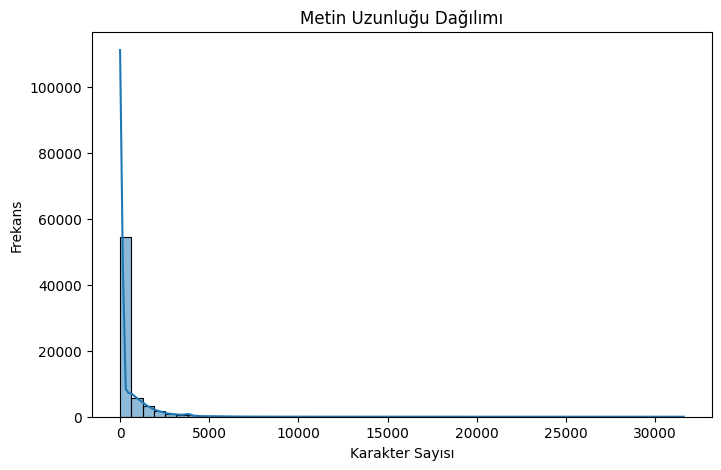

count    67742.000000
mean       395.023501
std       1036.703626
min          0.000000
25%          0.000000
50%          0.000000
75%        296.000000
max      31611.000000
Name: text_length, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df["text_length"] =df["complaint_what_happened"].astype(str).apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Metin Uzunluğu Dağılımı")
plt.xlabel("Karakter Sayısı")
plt.ylabel("Frekans")
plt.show()

print(df["text_length"].describe())


=== Ürün Kategorileri ve Sayıları ===
product
Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                                                   228
Payday l

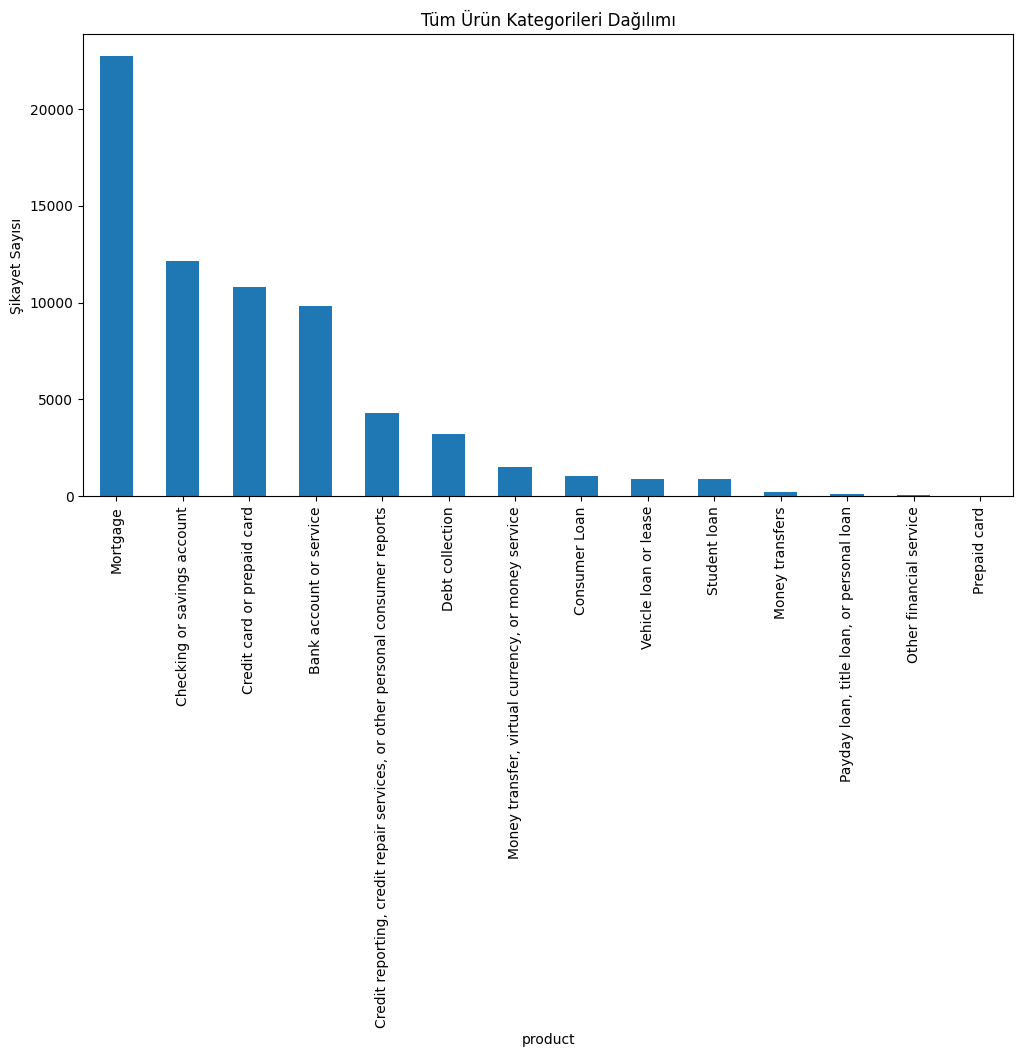

In [ ]:

product_counts = df["product"].value_counts()

print("=== Ürün Kategorileri ve Sayıları ===")
print(product_counts)

print("\n=== Ürün Kategorileri Oran (%) ===")
print((df["product"].value_counts(normalize=True) * 100).round(2))

plt.figure(figsize=(12,6))
product_counts.plot(kind="bar")
plt.title("Tüm Ürün Kategorileri Dağılımı")
plt.ylabel("Şikayet Sayısı")
plt.xticks(rotation=90)
plt.show()


=== Alt Ürün Kategorileri ve Sayıları ===
sub_product
Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
Medical debt                                      2
ID prepaid card                                   2
Electronic Benefit Transfer / EBT card            1
Name: count, Length: 72, dtype: int64

=== Alt Ürün Kategorileri Oran (%) ===
sub_product
Checking account                              25.36
General-purpose credit card or charge card    15.51
Other mortgage                                12.47
Conventional fixed mortgage                    7.22
Credit reporting                               6.16
                        

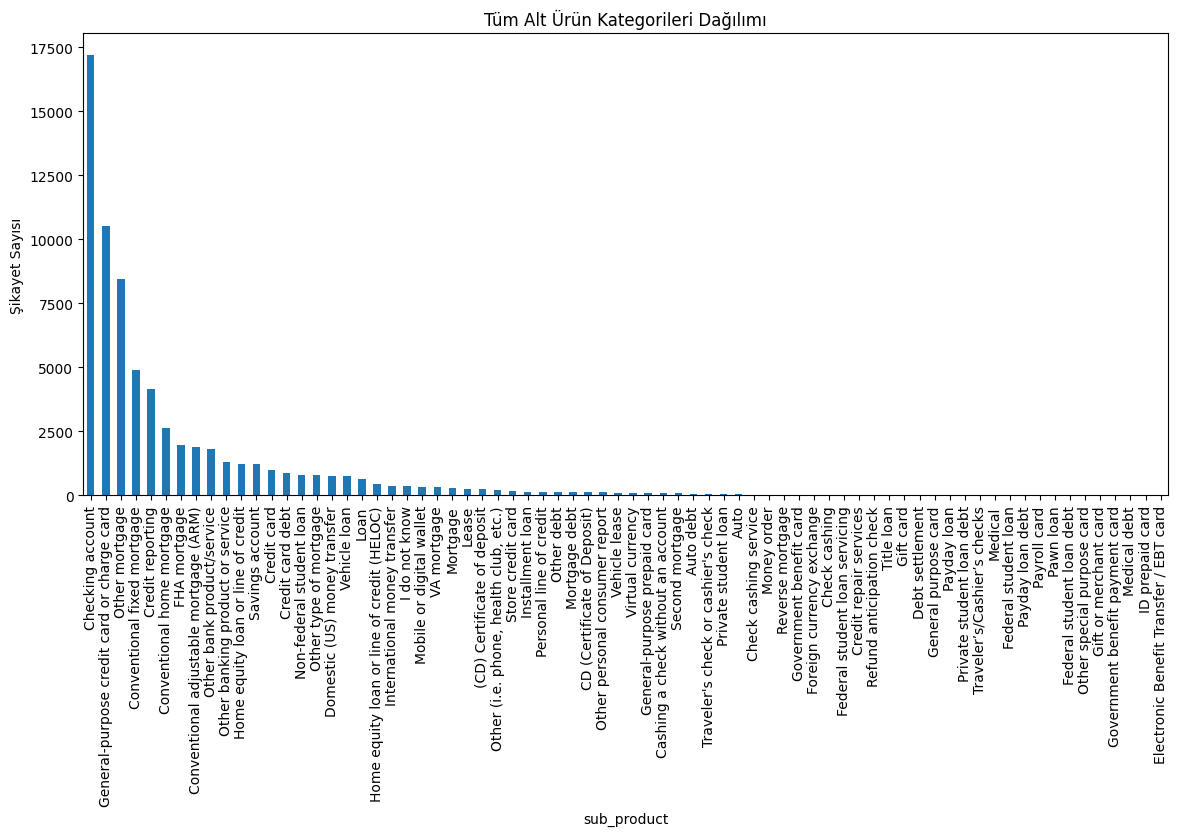

In [ ]:
sub_product_counts = df["sub_product"].value_counts()

print("=== Alt Ürün Kategorileri ve Sayıları ===")
print(sub_product_counts)

print("\n=== Alt Ürün Kategorileri Oran (%) ===")
print((df["sub_product"].value_counts(normalize=True) * 100).round(2))

plt.figure(figsize=(14,6))
sub_product_counts.plot(kind="bar")
plt.title("Tüm Alt Ürün Kategorileri Dağılımı")
plt.ylabel("Şikayet Sayısı")
plt.xticks(rotation=90)
plt.show()


=== Ürün ve Alt Ürün Bazlı Şikayet Sayıları ===
                                      product  \
16                Credit card or prepaid card   
6                 Checking or savings account   
60                                   Mortgage   
2                     Bank account or service   
55                                   Mortgage   
..                                        ...   
33                            Debt collection   
69                    Other financial service   
80                               Prepaid card   
76                               Prepaid card   
72  Payday loan, title loan, or personal loan   

                                   sub_product  count  
16  General-purpose credit card or charge card  10504  
6                             Checking account  10066  
60                              Other mortgage   8447  
2                             Checking account   7116  
55                 Conventional fixed mortgage   4892  
..                         

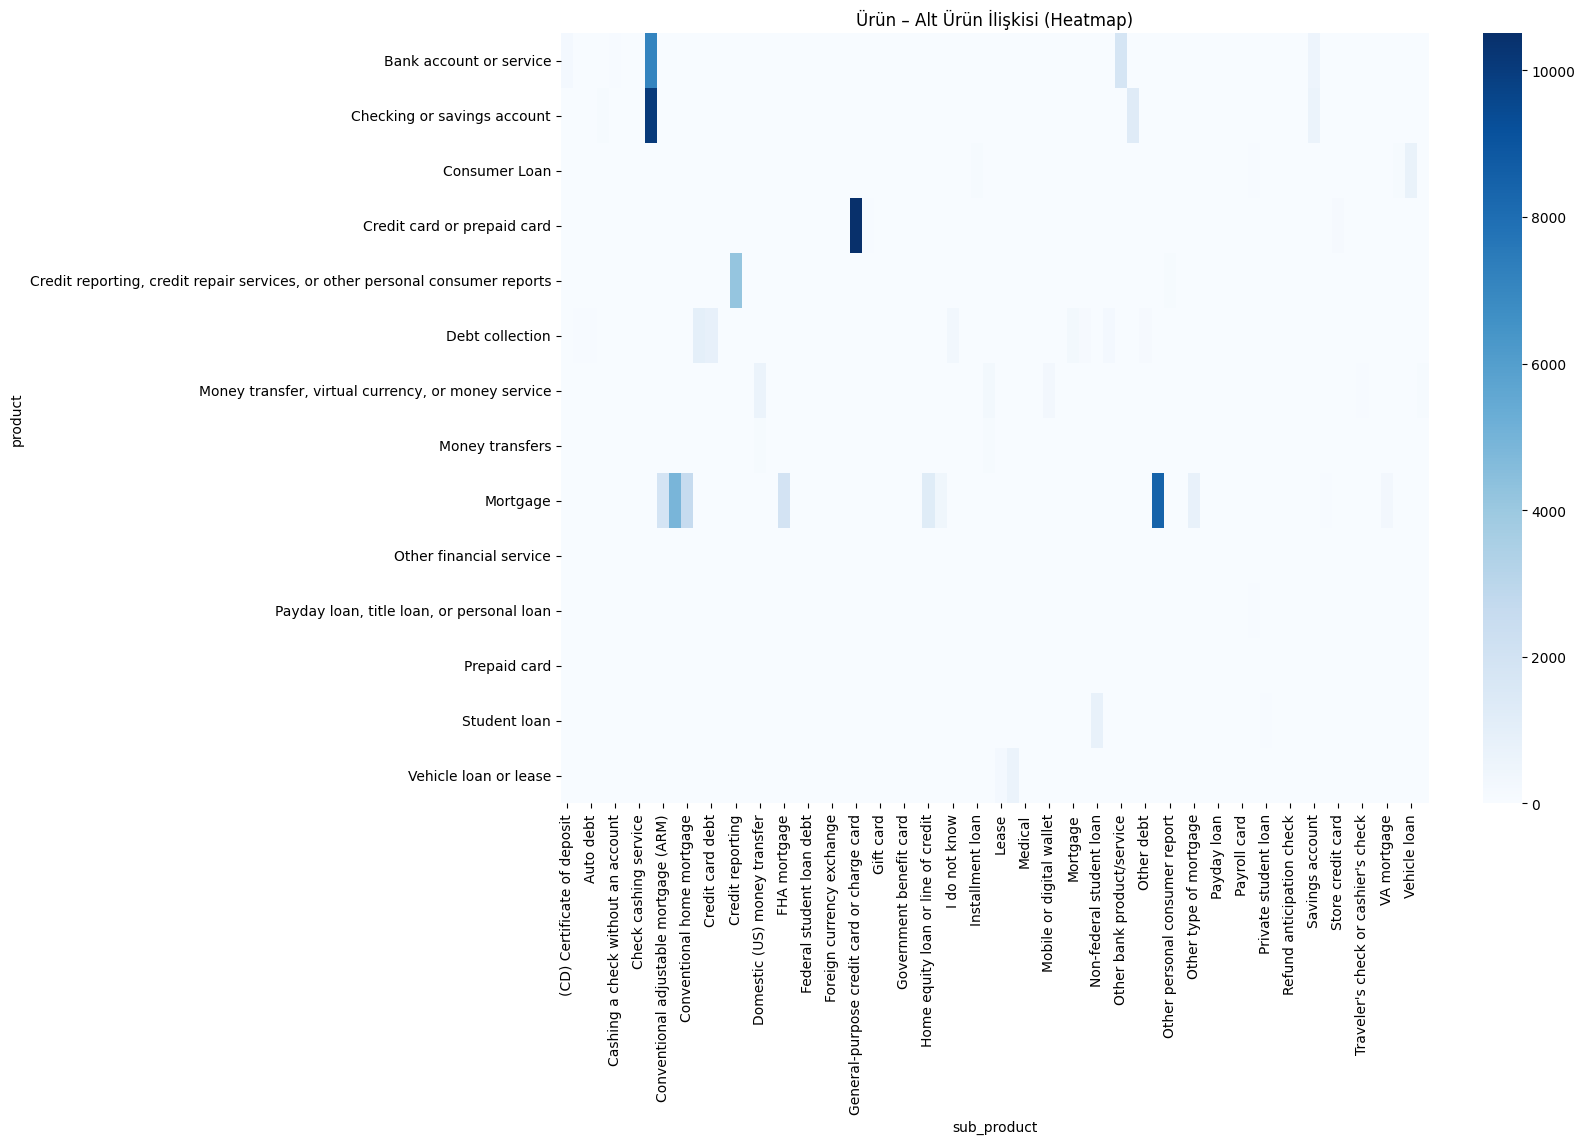

In [ ]:
cross_counts = df.groupby(["product","sub_product"]).size().reset_index(name="count")

print("=== Ürün ve Alt Ürün Bazlı Şikayet Sayıları ===")
print(cross_counts.sort_values("count", ascending=False))

plt.figure(figsize=(14,10))
subset = df.groupby(["product","sub_product"]).size().unstack(fill_value=0)
sns.heatmap(subset, cmap="Blues")
plt.title("Ürün – Alt Ürün İlişkisi (Heatmap)")
plt.show()


In [ ]:
product_sub_map = df.groupby("product")["sub_product"].unique()

product_sub_df = product_sub_map.reset_index()
product_sub_df.columns = ["product", "sub_products"]

print(product_sub_df)

                                              product  \
0                             Bank account or service   
1                         Checking or savings account   
2                                       Consumer Loan   
3                         Credit card or prepaid card   
4   Credit reporting, credit repair services, or o...   
5                                     Debt collection   
6   Money transfer, virtual currency, or money ser...   
7                                     Money transfers   
8                                            Mortgage   
9                             Other financial service   
10          Payday loan, title loan, or personal loan   
11                                       Prepaid card   
12                                       Student loan   
13                              Vehicle loan or lease   

                                         sub_products  
0   [Checking account, Cashing a check without an ...  
1   [Checking account, Savings a

In [ ]:
product_sub_count = df.groupby(["product", "sub_product"]).size().reset_index(name="count")

print(product_sub_count.sort_values(["product","count"], ascending=[True,False]))


                    product                         sub_product  count
2   Bank account or service                    Checking account   7116
3   Bank account or service          Other bank product/service   1822
4   Bank account or service                     Savings account    562
0   Bank account or service         (CD) Certificate of deposit    239
1   Bank account or service  Cashing a check without an account     77
..                      ...                                 ...    ...
83             Student loan            Non-federal student loan    787
84             Student loan                Private student loan     54
82             Student loan      Federal student loan servicing     25
86    Vehicle loan or lease                                Loan    650
85    Vehicle loan or lease                               Lease    242

[87 rows x 3 columns]


In [ ]:
import plotly.express as px

fig = px.treemap(product_sub_count,
                 path=["product", "sub_product"],
                 values="count",
                 title="Product - Sub_product Dağılımı")
fig.show()


In [ ]:
X = df["complaint_what_happened"].astype(str)
y = df["product"]

print("Toplam kayıt:", len(X))
print("Sınıf sayısı:", y.nunique())

Toplam kayıt: 67742
Sınıf sayısı: 14


In [ ]:
import re, string, nltk, pandas as pd
from nltk.corpus import stopwords as nltk_stopwords

# Stopwords indir
nltk.download('stopwords')

# İngilizce stopwords seti
stopword_set = set(nltk_stopwords.words('english'))

def preprocess(text):
    text = "" if pd.isna(text) else str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)                 # URL'leri sil
    text = re.sub(r"\s+", " ", text)                             # fazla boşlukları tekille
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # noktalama sil
    text = " ".join(w for w in text.split() if w not in stopword_set)  # stopwords temizle
    return text.strip()

# Metin kolonu: complaint_what_happened  ->  clean_text
df["clean_text"] = df["complaint_what_happened"].astype(str).apply(preprocess)

# Kontrol
df[["complaint_what_happened", "clean_text"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,complaint_what_happened,clean_text
0,,
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx2018 told agent up...
3,,
4,,


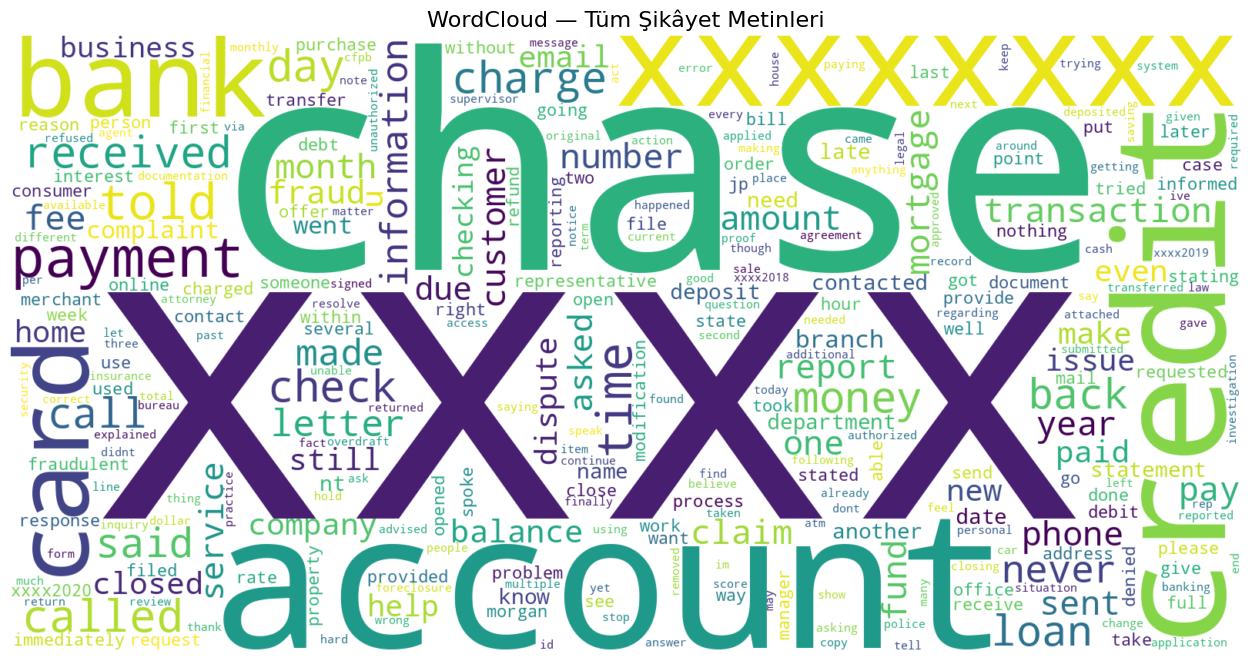

In [ ]:
from wordcloud import WordCloud
text_all = " ".join(df["clean_text"].astype(str))

wc = WordCloud(
    width=1600, height=800,
    background_color="white",
    max_words=300,
    collocations=False
).generate(text_all)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud — Tüm Şikâyet Metinleri", fontsize=16)
plt.show()



In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Sınıflar:", list(encoder.classes_))




Sınıflar: ['Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Credit card or prepaid card', 'Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Mortgage', 'Other financial service', 'Payday loan, title loan, or personal loan', 'Prepaid card', 'Student loan', 'Vehicle loan or lease']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
MAX_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")


# LSTM


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

X_train_pad = X_train_pad.astype("int32")
X_test_pad  = X_test_pad.astype("int32")
y_train     = np.asarray(y_train, dtype="int32")
y_test      = np.asarray(y_test,  dtype="int32")

vocab_size  = min(MAX_WORDS, len(tokenizer.word_index) + 1)
seq_len     = int(X_train_pad.shape[1])
num_classes = int(len(np.unique(y_train)))

print(f"seq_len={seq_len}, vocab_size={vocab_size}, num_classes={num_classes}")

def build_lstm_model(vocab_size=vocab_size, seq_len=seq_len, num_classes=num_classes,
                     emb_dim=64, lstm_units=64, drop=0.3, recurrent_drop=0.0):
    model = Sequential()

    model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_shape=(seq_len,), mask_zero=True))
    model.add(LSTM(lstm_units, dropout=drop, recurrent_dropout=recurrent_drop))
    model.add(Dropout(drop))

    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss_fn = 'binary_crossentropy'
    else:
        model.add(Dense(num_classes, activation='softmax'))
        loss_fn = 'sparse_categorical_crossentropy'

    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    return model

tf.keras.backend.clear_session()
lstm_model = build_lstm_model()


classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score


# Tahmin
y_proba = lstm_model.predict(X_test_pad, batch_size=64, verbose=1)
y_pred  = (y_proba.ravel() >= 0.5).astype(int) if y_proba.shape[1]==1 else y_proba.argmax(axis=1)

# Sınıf isimleri
if 'encoder' in globals():
    class_names = list(encoder.classes_)
else:
    class_names = [str(c) for c in sorted(np.unique(y_train))]

print("\ LSTM Sınıflandırma Raporu ")
print(classification_report(y_test, y_pred, target_names=class_names, digits=2, zero_division=0))
print(f"LSTM Doğruluk: %{accuracy_score(y_test, y_pred)*100:.2f}")

# Confusion matrix (TABLO)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.index.name = 'True'; cm_df.columns.name = 'Pred'


print('=== Confusion Matrix ===')
display(cm_df)


<>:16: SyntaxWarning:

invalid escape sequence '\ '

<>:16: SyntaxWarning:

invalid escape sequence '\ '

/tmp/ipython-input-96578291.py:16: SyntaxWarning:

invalid escape sequence '\ '



212/212 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step
\ LSTM Sınıflandırma Raporu 
                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00      1963
                                                 Checking or savings account       0.00      0.00      0.00      2430
                                                               Consumer Loan       0.00      0.00      0.00       206
                                                 Credit card or prepaid card       0.20      0.00      0.00      2160
Credit reporting, credit repair services, or other personal consumer reports       0.45      0.12      0.19       862
                                                             Debt collection       0.00      0.00      0.00       640
                          Money transfer, virtual currency, or money service       0.04      0.51    

Pred,Bank account or service,Checking or savings account,Consumer Loan,Credit card or prepaid card,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Money transfers,Mortgage,Other financial service,"Payday loan, title loan, or personal loan",Prepaid card,Student loan,Vehicle loan or lease
True,,,,,,,,,,,,,,
Bank account or service,0,0,0,0,8,0,322,0,1633,0,0,0,0,0
Checking or savings account,0,0,0,3,20,0,863,0,1544,0,0,0,0,0
Consumer Loan,0,0,0,0,1,0,38,0,167,0,0,0,0,0
Credit card or prepaid card,0,2,0,2,47,0,974,0,1135,0,0,0,0,0
"Credit reporting, credit repair services, or other personal consumer reports",0,2,0,3,104,0,329,0,424,0,0,0,0,0
Debt collection,0,1,0,2,12,0,172,0,453,0,0,0,0,0
"Money transfer, virtual currency, or money service",0,0,0,0,3,0,153,0,144,0,0,0,0,0
Money transfers,0,0,0,0,1,0,11,0,34,0,0,0,0,0
Mortgage,0,0,0,0,32,0,632,0,3881,0,0,0,0,0


In [ ]:
product_sub_counts = (
    df.groupby(["product","sub_product"]).size()
         .reset_index(name="count")
         .sort_values(["product","count"], ascending=[True, False])
)

display(product_sub_counts)


,product,sub_product,count
2,Bank account or service,Checking account,7116
3,Bank account or service,Other bank product/service,1822
4,Bank account or service,Savings account,562
0,Bank account or service,(CD) Certificate of deposit,239
1,Bank account or service,Cashing a check without an account,77
...,...,...,...
83,Student loan,Non-federal student loan,787
84,Student loan,Private student loan,54
82,Student loan,Federal student loan servicing,25
86,Vehicle loan or lease,Loan,650


 Mortgage | Top 20 kelime 


,word,count
0,xxxx,37420
1,chase,15114
2,loan,6826
3,mortgage,6681
4,xxxxxxxx,5629
5,payment,4101
6,would,3775
7,bank,3439
8,home,3428
9,payments,2765


 Bank account or service | Top 20 kelime


,word,count
0,xxxx,13850
1,chase,6073
2,account,5416
3,bank,3823
4,check,1903
5,money,1750
6,would,1657
7,told,1542
8,card,1266
9,nt,1211


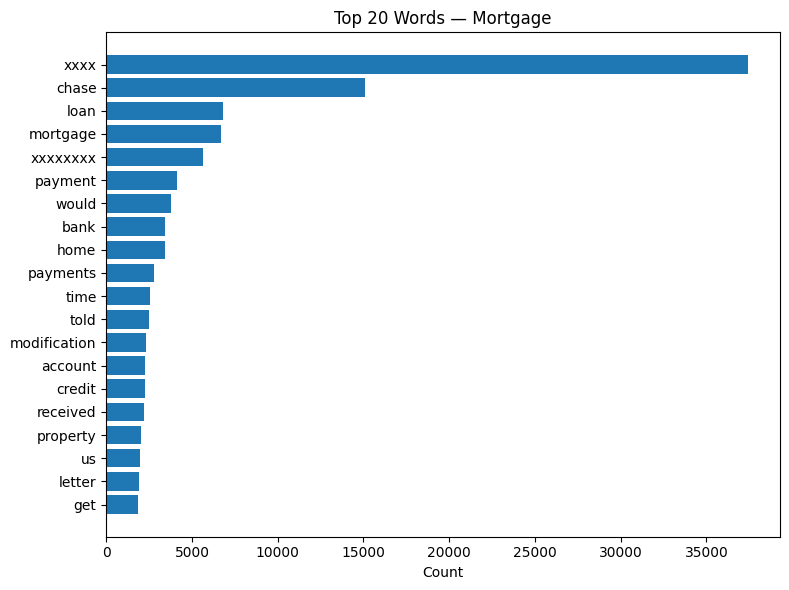

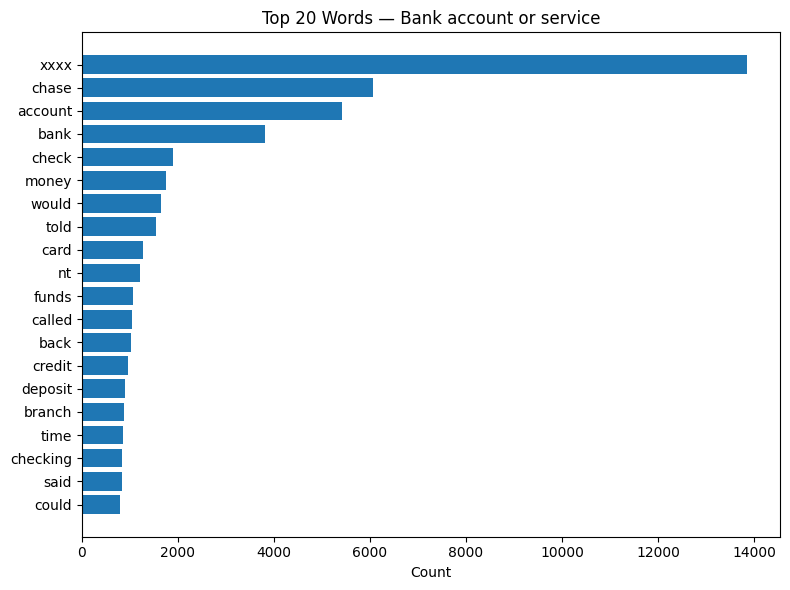

In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# Eğer temiz metin kolonun yoksa şu satırı kullan:
# df["clean_text"] = df["complaint_what_happened"].astype(str).str.lower()

def top_n_words_by_product(df, product_name, text_col="clean_text", n=20):
    # İlgili product kayıtları
    texts = df.loc[df["product"] == product_name, text_col].dropna().astype(str)
    # Tüm metinleri birleştir
    all_text = " ".join(texts).lower()
    # Basit tokenizasyon (harf/rakam grupları)
    tokens = re.findall(r"\b\w+\b", all_text)
    # Tek harfleri at (istersen kaldır)
    tokens = [t for t in tokens if len(t) > 1]
    # Sayım
    counts = Counter(tokens).most_common(n)
    return pd.DataFrame(counts, columns=["word", "count"])

# İki product için top-20
top20_mortgage = top_n_words_by_product(df, "Mortgage")
top20_bank     = top_n_words_by_product(df, "Bank account or service")

print(" Mortgage | Top 20 kelime ")
display(top20_mortgage)

print(" Bank account or service | Top 20 kelime")
display(top20_bank)

# (İsteğe bağlı) Görselleştir
def plot_top(df_top, title):
    plt.figure(figsize=(8, 6))
    plt.barh(df_top["word"][::-1], df_top["count"][::-1])
    plt.title(title)
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

plot_top(top20_mortgage, "Top 20 Words — Mortgage")
plot_top(top20_bank, "Top 20 Words — Bank account or service")



# X temizlik


In [ ]:
import re
import pandas as pd

src_col = "clean_text" if "clean_text" in df.columns else "complaint_else_happened"

pat_8 = r"(?i)(?<!\w)x{8}(?!\w)"
pat_4 = r"(?i)(?<!\w)x{4}(?!\w)"

dst_col = f"{src_col}_x"

before_8 = df[src_col].str.contains(r"(?i)\bx{8}\b", regex=True, na=False).sum()
before_4 = df[src_col].str.contains(r"(?i)\bx{4}\b", regex=True, na=False).sum()

df[dst_col] = (df[src_col]
               .str.replace(pat_8, " ", regex=True)
               .str.replace(r"(?i)\b\w*x{4,}\w*\b"," ", regex=True)
               .str.replace(pat_4, " ", regex=True)
               .str.replace(r"\s+", " ", regex=True)
               .str.strip())

after_8 = df[dst_col].str.contains(r"(?i)\bx{8}\b", regex=True, na=False).sum()
after_4 = df[dst_col].str.contains(r"(?i)\bx{4}\b", regex=True, na=False).sum()

print(f"Kullanılan kaynak kolon: {src_col}")
print(f"Yeni kolon: {dst_col}")
print(f"Önce  xxxxxxxx sayısı: {before_8}  →  Sonra: {after_8}")
print(f"Önce  xxxx     sayısı: {before_4}  →  Sonra: {after_4}")


df[[src_col, dst_col]].head(10)


Kullanılan kaynak kolon: clean_text
Yeni kolon: clean_text_x
Önce  xxxxxxxx sayısı: 6350  →  Sonra: 0
Önce  xxxx     sayısı: 15403  →  Sonra: 0


,clean_text,clean_text_x
0,,
1,good morning name xxxx xxxx appreciate could h...,good morning name appreciate could help put st...
2,upgraded xxxx xxxx card xxxx2018 told agent up...,upgraded card told agent upgrade anniversary d...
3,,
4,,
5,,
6,,
7,,
8,,
9,,


 Mortgage | Top 20 kelime 


,word,count
0,chase,15114
1,loan,6826
2,mortgage,6681
3,payment,4101
4,would,3775
5,bank,3439
6,home,3428
7,payments,2765
8,time,2577
9,told,2488


 Bank account or service | Top 20 kelime


,word,count
0,chase,6073
1,account,5416
2,bank,3823
3,check,1903
4,money,1750
5,would,1657
6,told,1542
7,card,1266
8,nt,1211
9,funds,1071


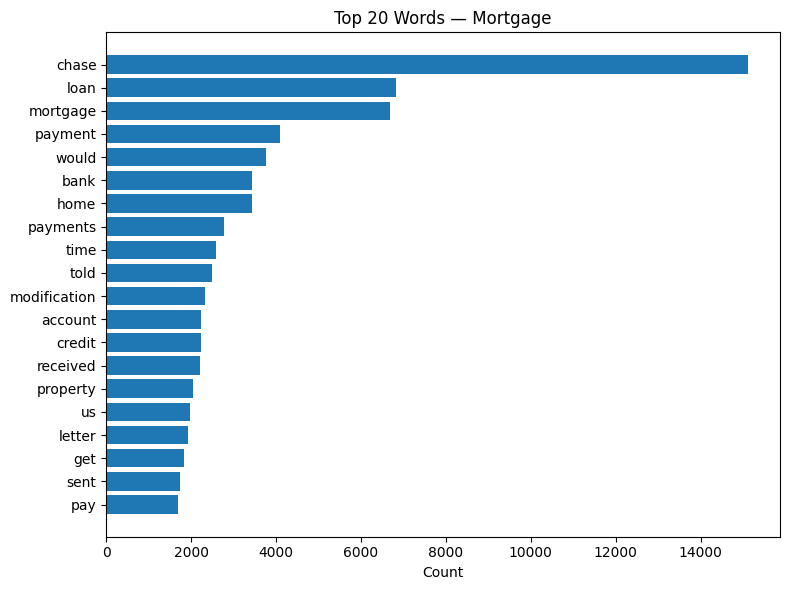

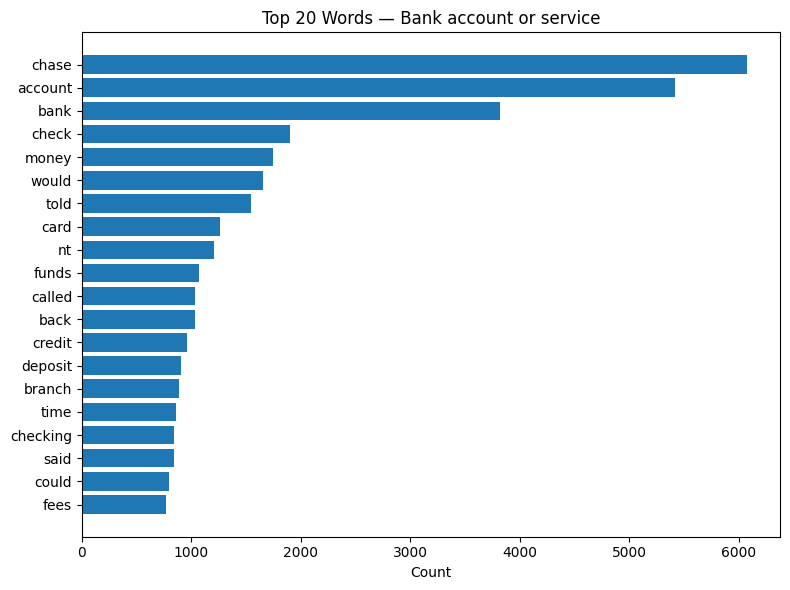

In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt


def top_n_words_by_product(df, product_name, text_col="clean_text_x", n=20):

    texts = df.loc[df["product"] == product_name, text_col].dropna().astype(str)
    all_text = " ".join(texts).lower()
    tokens = re.findall(r"\b\w+\b", all_text)

    tokens = [t for t in tokens if len(t) > 1]

    counts = Counter(tokens).most_common(n)
    return pd.DataFrame(counts, columns=["word", "count"])

top20_mortgage = top_n_words_by_product(df, "Mortgage")
top20_bank     = top_n_words_by_product(df, "Bank account or service")

print(" Mortgage | Top 20 kelime ")
display(top20_mortgage)

print(" Bank account or service | Top 20 kelime")
display(top20_bank)


def plot_top(df_top, title):
    plt.figure(figsize=(8, 6))
    plt.barh(df_top["word"][::-1], df_top["count"][::-1])
    plt.title(title)
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

plot_top(top20_mortgage, "Top 20 Words — Mortgage")
plot_top(top20_bank, "Top 20 Words — Bank account or service")



In [ ]:

# ===== TAM VERİ İLE TEMİZ AKIŞ =====
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# 0) Parametreler
TEXT_COL   = "clean_text_x"     # metin kolonun
TARGET_COL = "product"          # hedef kolonun
MAX_WORDS  = 20000

assert TEXT_COL in df.columns and TARGET_COL in df.columns

# 1) SADECE etiketi olan satırları al; metin NaN -> ''
mask = df[TARGET_COL].notna()
X_text_all    = df.loc[mask, TEXT_COL].fillna("").astype(str).to_numpy()
y_labels_all  = df.loc[mask, TARGET_COL].astype(str).to_numpy()
print("Toplam örnek (etiketi olan):", len(X_text_all))
print("Toplam sınıf:", len(y_labels_all))

# 2) Etiket kodlama + SABİT split
encoder = LabelEncoder()
y_all = encoder.fit_transform(y_labels_all)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
tr_idx, te_idx = next(sss.split(X_text_all, y_all))

X_tr_txt, X_te_txt = X_text_all[tr_idx], X_text_all[te_idx]
y_tr, y_te         = y_all[tr_idx], y_all[te_idx]
num_classes        = len(encoder.classes_)
print("Train:", len(X_tr_txt), "Test:", len(X_te_txt), "Sınıf sayısı:", num_classes)

# Test destek dağılımını TEYİT ET
test_support = pd.Series(y_te).value_counts().sort_index()
support_df = pd.DataFrame({"class": list(encoder.classes_), "support": test_support}).fillna(0).astype({"support":int})
print("\n=== Test support (gerçek sayılar) ===")
#display(support_df)
print("Support toplamı:", int(support_df["support"].sum()))

print("------------------------------------------")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train:", len(X_train), "Test:", len(X_test))
test_support = pd.Series(y_test).value_counts().sort_index()
support_df2 = pd.DataFrame({"class": list(encoder.classes_), "support": test_support}).fillna(0).astype({"support":int})
display(support_df2)
# 3




Toplam örnek (etiketi olan): 67742
Toplam sınıf: 67742
Train: 54193 Test: 13549 Sınıf sayısı: 14

=== Test support (gerçek sayılar) ===
Support toplamı: 13549
------------------------------------------
Train: 54193 Test: 13549


,class,support
0,Bank account or service,1963
1,Checking or savings account,2430
2,Consumer Loan,206
3,Credit card or prepaid card,2160
4,"Credit reporting, credit repair services, or o...",862
5,Debt collection,640
6,"Money transfer, virtual currency, or money ser...",300
7,Money transfers,46
8,Mortgage,4545
9,Other financial service,12


# Clean_text_x + LSTM


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

TEXT_COL = "clean_text_x"
TARGET_COL = "product"
assert TEXT_COL in df.columns and TARGET_COL in df.columns

mask = df[TARGET_COL].notna()
X_text   = df.loc[mask, TEXT_COL].fillna("").astype(str).to_numpy()
y_labels = df.loc[mask, TARGET_COL].astype(str).to_numpy()
print("Toplam örnek (etiketi olan):", len(X_text))

encoder = LabelEncoder()
y = encoder.fit_transform(y_labels)
X_tr, X_te, y_tr, y_te = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)
num_classes = len(encoder.classes_)
print("Sınıf sayısı:", num_classes)
print("Train:", len(X_tr), "Test:", len(X_te))


MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_tr)

seq_tr = tokenizer.texts_to_sequences(X_tr)
seq_te = tokenizer.texts_to_sequences(X_te)


lens = np.array([len(s) for s in seq_tr if len(s)>0] + [1])
MAX_LEN = int(np.clip(np.percentile(lens, 90), 40, 300))
print("MAX_LEN:", MAX_LEN)

X_tr_pad = pad_sequences(seq_tr, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
X_te_pad = pad_sequences(seq_te, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)


opt = tf.keras.optimizers.Adam(learning_rate=2e-4, clipnorm=1.0)

def build_lstm_model(vocab_size, seq_len, num_classes,
                     emb_dim=128, lstm_units=64, drop=0.5, rdrop=0.2):
    m = Sequential([
        Input(shape=(seq_len,), dtype="int32"),
        Embedding(vocab_size, emb_dim, mask_zero=True),
        LSTM(lstm_units, return_sequences=True, dropout=drop, recurrent_dropout=rdrop),
        Bidirectional(LSTM(lstm_units, dropout=drop, recurrent_dropout=rdrop)),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m


tf.keras.backend.clear_session()
model = build_lstm_model(vocab_size=vocab_size, seq_len=MAX_LEN, num_classes=num_classes)


classes = np.unique(y_tr)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("class_weights:", class_weights)

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=2e-5, verbose=1)


history = model.fit(
    X_tr_pad, y_tr,
    validation_data=(X_te_pad, y_te),
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


y_proba = model.predict(X_te_pad, batch_size=256, verbose=0)
y_pred  = y_proba.argmax(axis=1)

print("\nLSTM Sınıflandırma Raporu ")
print(classification_report(y_te, y_pred, target_names=list(encoder.classes_),
                            digits=2, zero_division=0))
print(f"Doğruluk: %{accuracy_score(y_te, y_pred)*100:.2f}")


true_counts = np.bincount(y_te, minlength=num_classes)
pred_counts = np.bincount(y_pred, minlength=num_classes)
dist_df = pd.DataFrame({
    "class": list(encoder.classes_),
    "true_count": true_counts,
    "pred_count": pred_counts
}).sort_values("true_count", ascending=False)
print("\nGerçek vs. Tahmin Dağılımı ")
display(dist_df)


Toplam örnek (etiketi olan): 67742
Sınıf sayısı: 14
Train: 54193 Test: 13549
MAX_LEN: 245
class_weights: {0: 0.49292354150370193, 1: 0.39836663285258533, 2: 4.703436903315397, 3: 0.44817975818323164, 4: 1.1226590984421612, 5: 1.511491047024042, 6: 3.2257738095238095, 7: 21.26883830455259, 8: 0.2129223636649379, 9: 80.64434523809524, 10: 34.87323037323037, 11: 148.88186813186815, 12: 5.585755514326943, 13: 5.421468587434974}
Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 999s 1s/step - accuracy: 0.2164 - loss: 2.5945 - val_accuracy: 0.3357 - val_loss: 2.5182 - learning_rate: 2.0000e-04
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 1039s 1s/step - accuracy: 0.3473 - loss: 2.5751 - val_accuracy: 0.3884 - val_loss: 2.3896 - learning_rate: 2.0000e-04
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 1033s 1s/step - accuracy: 0.3785 - loss: 2.4548 - val_accuracy: 0.3968 - val_loss: 2.3294 - learning_rate: 2.0000e-04
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 1038s 1s/step - accuracy: 0.3859 - loss: 2.4085 - val_accur

,class,true_count,pred_count
8,Mortgage,4545,9817
1,Checking or savings account,2430,894
3,Credit card or prepaid card,2160,947
0,Bank account or service,1963,31
4,"Credit reporting, credit repair services, or o...",862,427
5,Debt collection,640,307
6,"Money transfer, virtual currency, or money ser...",300,350
2,Consumer Loan,206,101
13,Vehicle loan or lease,178,132
12,Student loan,173,341


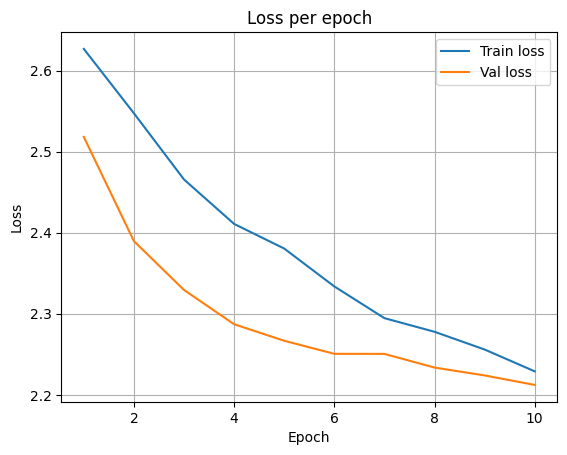

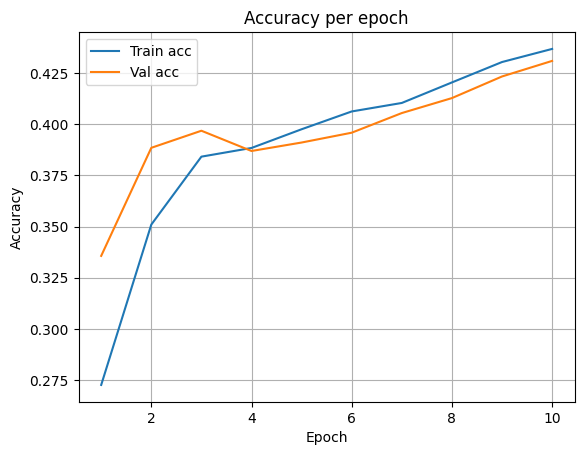

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure()
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in hist and 'val_accuracy' in hist:
    plt.figure()
    plt.plot(epochs, hist['accuracy'], label='Train acc')
    plt.plot(epochs, hist['val_accuracy'], label='Val acc')
    plt.title('Accuracy per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("history.metrics içinde accuracy bulunamadı.")


In [ ]:
# === Colab Drive güvenli bağlan + kaydet (tek hücre) ===
from google.colab import drive, auth
import os, time, json, pickle

def safe_mount():
    try:
        drive.mount('/content/drive')                     # normal dene
    except Exception as e:
        print("İlk mount başarısız:", e)
        try:
            drive.flush_and_unmount()                     # eski bağlantıyı temizle
        except Exception:
            pass
        auth.authenticate_user()                          # kullanıcı doğrulaması
        drive.mount('/content/drive', force_remount=True) # zorla yeniden bağla

safe_mount()

# ---- KAYIT KLASÖRÜ ----
TS   = time.strftime("%Y%m%d_%H%M%S")
BASE = f"/content/drive/MyDrive/models/lstm_product_{TS}"
os.makedirs(BASE, exist_ok=True)
print("Kayıt klasörü:", BASE)

# ---- GEREKLİ NESNELERİN VARLIĞINI KONTROL ET ----
assert 'model' in globals(), "model yok"
assert 'tokenizer' in globals(), "tokenizer yok"
assert 'encoder' in globals(), "encoder (LabelEncoder) yok"

# ---- 1) MODELİ KAYDET (.h5 istersen .keras da olabilir) ----
model.save(f"{BASE}/model.h5")
print(" Model ->", f"{BASE}/model.h5")

# ---- 2) TOKENIZER ----
with open(f"{BASE}/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
print("Tokenizer ->", f"{BASE}/tokenizer.json")

# ---- 3) LABEL ENCODER ----
with open(f"{BASE}/label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
print("LabelEncoder ->", f"{BASE}/label_encoder.pkl")

# ---- 4) META (MAX_LEN vb.) ----
meta = {
    "TEXT_COL": "clean_text_x",
    "classes":  list(getattr(encoder, "classes_", [])),
    "MAX_LEN":  int(globals().get("MAX_LEN", -1)),
    "MAX_WORDS":int(globals().get("MAX_WORDS", -1)),
    "vocab_size": int(globals().get("vocab_size", -1))
}
with open(f"{BASE}/meta.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print(" Meta :", f"{BASE}/meta.json")

# (opsiyonel) eğitim geçmişi de kaydet
if 'history' in globals() and hasattr(history, "history"):
    import pandas as pd
    pd.DataFrame(history.history).to_csv(f"{BASE}/history.csv", index=False)
    print(" History :", f"{BASE}/history.csv")

print("\n İçerik:", os.listdir(BASE))


Mounted at /content/drive


Kayıt klasörü: /content/drive/MyDrive/models/lstm_product_20250829_110038
✅ Model -> /content/drive/MyDrive/models/lstm_product_20250829_110038/model.h5
✅ Tokenizer -> /content/drive/MyDrive/models/lstm_product_20250829_110038/tokenizer.json
✅ LabelEncoder -> /content/drive/MyDrive/models/lstm_product_20250829_110038/label_encoder.pkl
✅ Meta -> /content/drive/MyDrive/models/lstm_product_20250829_110038/meta.json
✅ History -> /content/drive/MyDrive/models/lstm_product_20250829_110038/history.csv

📂 İçerik: ['model.h5', 'tokenizer.json', 'label_encoder.pkl', 'meta.json', 'history.csv']


In [ ]:
BASE = "/content/drive/MyDrive/models/lstm_product_20250829_110038"
model.save(f"{BASE}/model.keras")
print("Kaydedildi →", f"{BASE}/model.keras")


Kaydedildi → /content/drive/MyDrive/models/lstm_product_20250829_110038/model.keras


In [ ]:
import json, pickle, numpy as np, pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

drive.mount("/content/drive")

BASE = "/content/drive/MyDrive/models/lstm_product_20250829_110038"

try:
    model = load_model(f"{BASE}/model.keras", compile=False)
except Exception:
    model = load_model(f"{BASE}/model.h5", compile=False)

with open(f"{BASE}/tokenizer.json","r") as f:
    tokenizer = tokenizer_from_json(f.read())

with open(f"{BASE}/label_encoder.pkl","rb") as f:
    encoder = pickle.load(f)

with open(f"{BASE}/meta.json") as f:
    meta = json.load(f)
MAX_LEN = int(meta["MAX_LEN"])


def predict_texts(texts):
    seqs = tokenizer.texts_to_sequences([str(t) for t in texts])
    pads = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")
    proba = model.predict(pads, verbose=0)
    pred  = proba.argmax(axis=1)
    labels = encoder.inverse_transform(pred)
    conf   = proba.max(axis=1)
    return labels, conf, proba




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,pred,confidence
0,Bank refused to reverse an unauthorized charge.,"Money transfer, virtual currency, or money ser...",0.253370
1,My mortgage payment was posted to the wrong ac...,Student loan,0.272721


# Random Oversampler


In [ ]:
import numpy as np, pandas as pd
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

TEXT_COL   = "clean_text_x"
TARGET_COL = "product"


# Sadece etiketi olan satırlar; metin NaN -> ""
mask = df[TARGET_COL].notna()
X = df.loc[mask, TEXT_COL].fillna("").astype(str).to_numpy()
y = df.loc[mask, TARGET_COL].astype(str).to_numpy()

print("ÖNCE (train adayları):")
display(pd.Series(y).value_counts())

counts    = Counter(y)
majority  = max(counts.values())
cap       = int(0.60 * majority)
strategy  = {cls: cap for cls, n in counts.items() if n < cap}



ros       = RandomOverSampler(sampling_strategy=strategy, random_state=42)
X_2d      = X.reshape(-1, 1)
X_bal_2d, y_bal = ros.fit_resample(X_2d, y)
X_bal     = X_bal_2d.ravel()

balanced_df = (pd.DataFrame({TEXT_COL: X_bal, TARGET_COL: y_bal})
                 .sample(frac=1.0, random_state=42)
                 .reset_index(drop=True))

print("SONRA (oversampling):")
display(balanced_df[TARGET_COL].value_counts())

balanced_df.to_json("balanced_clean_text_x.json", orient="records", force_ascii=False)


ÖNCE (train adayları):


,count
Mortgage,22725
Checking or savings account,12147
Credit card or prepaid card,10797
Bank account or service,9816
"Credit reporting, credit repair services, or other personal consumer reports",4310
Debt collection,3201
"Money transfer, virtual currency, or money service",1500
Consumer Loan,1029
Vehicle loan or lease,892
Student loan,866


SONRA (oversampling):


,count
product,
Mortgage,22725
"Money transfer, virtual currency, or money service",13635
Prepaid card,13635
Credit card or prepaid card,13635
Debt collection,13635
Student loan,13635
Checking or savings account,13635
"Payday loan, title loan, or personal loan",13635
Other financial service,13635


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

CKPT_DIR = "/content/drive/MyDrive/models/lstm_checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

class SaveEveryNEpochs(Callback):
    def __init__(self, n=5, base_dir=CKPT_DIR, save_weights_only=True):
        super().__init__()
        self.n = n
        self.base_dir = base_dir
        self.save_weights_only = save_weights_only

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        if ep % self.n == 0:
            val_loss = logs.get("val_loss", None)
            if self.save_weights_only:
                fname = f"epoch{ep:03d}-val{val_loss:.4f}.weights.h5" if val_loss is not None else f"epoch{ep:03d}.weights.h5"
                self.model.save_weights(os.path.join(self.base_dir, fname))
            else:
                fname = f"epoch{ep:03d}-val{val_loss:.4f}.keras" if val_loss is not None else f"epoch{ep:03d}.keras"
                self.model.save(os.path.join(self.base_dir, fname))
            print(f"\n Saved checkpoint: {os.path.join(self.base_dir, fname)}")


X_text = balanced_df[TEXT_COL].astype(str).to_numpy()
y_cat  = balanced_df[TARGET_COL].to_numpy()

encoder = LabelEncoder()
y_enc   = encoder.fit_transform(y_cat)

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
num_classes = len(encoder.classes_)
print("Sınıf sayısı:", num_classes)


MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

lens    = np.array([len(s) for s in X_train_seq if len(s) > 0] + [1])
MAX_LEN = int(np.clip(np.percentile(lens, 90), 40, 300))
print("MAX_LEN:", MAX_LEN)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
vocab_size  = min(MAX_WORDS, len(tokenizer.word_index) + 1)


model = Sequential([
    Input(shape=(MAX_LEN,), dtype="int32"),
    Embedding(vocab_size, 128, mask_zero=True),
    LSTM(64, dropout=0.5, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=1)
save5_cb = SaveEveryNEpochs(n=5, base_dir=CKPT_DIR, save_weights_only=True)  # her 5 epoch'ta weights kaydet
best_ckpt = ModelCheckpoint(
    filepath=os.path.join(CKPT_DIR, "best-val_loss.weights.h5"),
    monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=25, batch_size=64,
    callbacks=[early_stop, reduce_lr,save5_cb, best_ckpt],
    verbose=1
)


y_proba = model.predict(X_test_pad, batch_size=256, verbose=0)
y_pred  = y_proba.argmax(axis=1)

print("\n=== LSTM Sınıflandırma Raporu ===\n")
print(classification_report(y_test, y_pred, target_names=list(encoder.classes_), digits=3, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

test_support = np.bincount(y_test, minlength=num_classes)
support_df = pd.DataFrame({"class": encoder.classes_,
                           "test_support": test_support}).sort_values("test_support", ascending=False)
display(support_df.head(10))

model.save(os.path.join(CKPT_DIR, "final_model.keras"))




Sınıf sayısı: 14
MAX_LEN: 238
Epoch 1/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.1617 - loss: 2.5295
Epoch 1: val_loss improved from inf to 2.21140, saving model to /content/drive/MyDrive/models/lstm_checkpoints/best-val_loss.weights.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1236s 492ms/step - accuracy: 0.1617 - loss: 2.5295 - val_accuracy: 0.2649 - val_loss: 2.2114 - learning_rate: 2.0000e-04
Epoch 2/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.2592 - loss: 2.2267
Epoch 2: val_loss improved from 2.21140 to 2.08559, saving model to /content/drive/MyDrive/models/lstm_checkpoints/best-val_loss.weights.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1277s 490ms/step - accuracy: 0.2592 - loss: 2.2266 - val_accuracy: 0.3033 - val_loss: 2.0856 - learning_rate: 2.0000e-04
Epoch 3/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.2913 - loss: 2.1256
Epoch 3: val_loss improved from 2.08559 to 2.03434, saving model to /content/drive/MyDrive/models/lstm_checkpoints/best-

,class,test_support
8,Mortgage,4545
0,Bank account or service,2727
2,Consumer Loan,2727
3,Credit card or prepaid card,2727
4,"Credit reporting, credit repair services, or o...",2727
1,Checking or savings account,2727
5,Debt collection,2727
6,"Money transfer, virtual currency, or money ser...",2727
7,Money transfers,2727
9,Other financial service,2727


In [ ]:
# 1) Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Yollar
import os, glob, json, pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

BASE = "/content/drive/MyDrive/models/lstm_product_20250829_110038"  # klasörün
MODEL_PATH = os.path.join(BASE, "model.h5")
TOK_PATH   = os.path.join(BASE, "tokenizer.json")      # varsa
ENC_PATH   = os.path.join(BASE, "label_encoder.pkl")   # varsa
META_PATH  = os.path.join(BASE, "meta.json")           # varsa (MAX_LEN sakladıysan)

# (İsteğe bağlı) klasörü kontrol et
print("Klasör:", BASE)
print("İçerik:", os.listdir(BASE))

# 3) Modeli yükle
model = load_model(MODEL_PATH)
print("✅ Model yüklendi:", MODEL_PATH)

# 4) Tokenizer’ı yükle (varsa)
tokenizer = None
if os.path.exists(TOK_PATH):
    with open(TOK_PATH, "r") as f:
        tok_json = f.read()            # string olarak oku (json.load değil)
    tokenizer = tokenizer_from_json(tok_json)
    print("✅ Tokenizer yüklendi")

# 5) LabelEncoder’ı yükle (varsa)
encoder = None
if os.path.exists(ENC_PATH):
    with open(ENC_PATH, "rb") as f:
        encoder = pickle.load(f)
    print("✅ LabelEncoder yüklendi")

# 6) MAX_LEN’i belirle (meta varsa ordan, yoksa modelin girişinden)
try:
    with open(META_PATH, "r") as f:
        meta = json.load(f)
    MAX_LEN = int(meta.get("max_len", model.input_shape[1]))
except FileNotFoundError:
    MAX_LEN = int(model.input_shape[1])
print("MAX_LEN:", MAX_LEN)



Mounted at /content/drive
Klasör: /content/drive/MyDrive/models/lstm_product_20250829_110038
İçerik: ['model.h5', 'tokenizer.json', 'label_encoder.pkl', 'meta.json', 'history.csv', 'model.keras']


✅ Model yüklendi: /content/drive/MyDrive/models/lstm_product_20250829_110038/model.h5
✅ Tokenizer yüklendi
✅ LabelEncoder yüklendi
MAX_LEN: 245


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

loss, acc = model.evaluate(X_test_pad, y_test, batch_size=256, verbose=0)
print(f"Test loss: {loss:.4f} | Test accuracy: {acc:.4f}")

y_proba = model.predict(X_test_pad, batch_size=256, verbose=0)
y_pred  = y_proba.argmax(axis=1)

print("\n=== Classification Report ===\n")
print(classification_report(y_test, y_pred, target_names=list(encoder.classes_),
                            digits=3, zero_division=0))


Test loss: 2.6847 | Test accuracy: 0.3325

=== Classification Report ===

                                                                              precision    recall  f1-score   support

                                                     Bank account or service      0.106     0.009     0.016      1963
                                                 Checking or savings account      0.222     0.077     0.114      2430
                                                               Consumer Loan      0.041     0.010     0.016       206
                                                 Credit card or prepaid card      0.294     0.155     0.203      2160
Credit reporting, credit repair services, or other personal consumer reports      0.173     0.015     0.028       862
                                                             Debt collection      0.051     0.075     0.061       640
                          Money transfer, virtual currency, or money service      0.040     0.017  

# SMOTE


In [ ]:

import numpy as np, pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from imblearn.over_sampling import SMOTE


TEXT_COL   = "clean_text_x"
TARGET_COL = "product"


mask        = df[TARGET_COL].notna()
X_text  = df.loc[mask, TEXT_COL].fillna("").astype(str).to_numpy()
y_labels  = df.loc[mask, TARGET_COL].astype(str).to_numpy()

encoder = LabelEncoder()
y = encoder.fit_transform(y_labels)
X_tr, X_te, y_tr, y_te = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)
num_classes = len(encoder.classes_)


before = Counter(y_tr)
print("TRAIN ÖNCE")
display(pd.DataFrame({
    "class": encoder.classes_,
    "train_before": [before.get(i,0) for i in range(num_classes)]
}).sort_values("train_before", ascending=False))

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
X_tr_tfidf = tfidf.fit_transform(X_tr_txt)

#TF-IDF çok yüksek boyutlu olduğu için → TruncatedSVD ile 300 boyuta kadar indiriliyor.
#Bu daha sonra SMOTE’un komşuluk tabanlı algoritmasını kolaylaştırıyor.
n_comp = int(min(300, max(1, X_tr_tfidf.shape[1]-1)))
svd    = TruncatedSVD(n_components=n_comp, random_state=42)
X_tr_svd = svd.fit_transform(X_tr_tfidf)
#TF-IDF çok yüksek boyutlu olduğu için → TruncatedSVD ile 300 boyuta kadar indiriliyor.
#Bu daha sonra SMOTE’un komşuluk tabanlı algoritmasını kolaylaştırıyor.
min_count = min(Counter(y_tr).values())
if min_count < 2:
    raise ValueError(f"SMOTE için her sınıfta en az 2 örnek gerekir. Min sınıf sayısı: {min_count}")

k = max(1, min(5, min_count - 1))
print(f"SMOTE k_neighbors = {k} (min_class_count={min_count})")

smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k)
X_tr_svd_sm, y_tr_sm = smote.fit_resample(X_tr_svd, y_tr)

#SMOTE sonrası her sınıfta kaç tane örnek olduğunu tablo halinde gösteriyor.

after_smote = Counter(y_tr_sm)
print("TRAIN SMOTE SONRASI ")
display(pd.DataFrame({
    "class": encoder.classes_,
    "train_after_smote": [after_smote.get(i,0) for i in range(num_classes)]
}).sort_values("train_after_smote", ascending=False))

#Burada sayısal uzaydaki SMOTE hedeflerini alıyor (after_smote).

#Ama bizde ham metinler var, SMOTE doğrudan metin üretemez.

#O yüzden:Her sınıf için SMOTE’in hedeflediği örnek sayısına (tgt) bakıyor.

#Eksik varsa, o sınıftan kopya metinler ekliyor (replace=True).

#Böylece metin tarafında da SMOTE’in dengelediği kadar örnek oluyor.
train_df = pd.DataFrame({"text": X_tr, "y": y_tr})
parts = []
for cls in range(num_classes):
    grp  = train_df[train_df["y"] == cls]
    tgt  = after_smote.get(cls, len(grp))
    need = tgt - len(grp)
    if need > 0:
        extra = grp.sample(n=need, replace=True, random_state=42)
        grp   = pd.concat([grp, extra], axis=0)
    parts.append(grp)

balanced_df_smote = (pd.concat(parts, axis=0)
                       .sample(frac=1.0, random_state=42)
                       .reset_index(drop=True))

balanced_df_smote = balanced_df_smote.rename(columns={"text": TEXT_COL, "y": "y_int"})
balanced_df_smote[TARGET_COL] = encoder.inverse_transform(balanced_df_smote["y_int"].to_numpy())

balanced_df_smote = balanced_df_smote[[TEXT_COL, TARGET_COL]]


print("=== Yeni DataFrame (SMOTE-hedefli, METİN) sınıf dağılımı ===")
display(balanced_df_smote[TARGET_COL].value_counts())


# balanced_df_smote.to_csv("balanced_product_smote.csv", index=False)
# balanced_df_smote.to_json("balanced_product_smote.json", orient="records", force_ascii=False)

print("balanced_df_smote hazır • Satır sayısı:", len(balanced_df_smote))


TRAIN ÖNCE


,class,train_before
8,Mortgage,18180
1,Checking or savings account,9717
3,Credit card or prepaid card,8637
0,Bank account or service,7853
4,"Credit reporting, credit repair services, or o...",3448
5,Debt collection,2561
6,"Money transfer, virtual currency, or money ser...",1200
2,Consumer Loan,823
13,Vehicle loan or lease,714
12,Student loan,693


SMOTE k_neighbors = 5 (min_class_count=26)
TRAIN SMOTE SONRASI 


,class,train_after_smote
0,Bank account or service,18180
1,Checking or savings account,18180
2,Consumer Loan,18180
3,Credit card or prepaid card,18180
4,"Credit reporting, credit repair services, or o...",18180
5,Debt collection,18180
6,"Money transfer, virtual currency, or money ser...",18180
7,Money transfers,18180
8,Mortgage,18180
9,Other financial service,18180


=== Yeni DataFrame (SMOTE-hedefli, METİN) sınıf dağılımı ===


,count
product,
"Money transfer, virtual currency, or money service",18180
Mortgage,18180
Checking or savings account,18180
Prepaid card,18180
Credit card or prepaid card,18180
Money transfers,18180
Student loan,18180
Debt collection,18180
Consumer Loan,18180


balanced_df_smote hazır • Satır sayısı: 254520


In [ ]:
print(balanced_df_smote.columns.tolist())


['clean_text_x', 'product']


In [ ]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

TEXT_COL   = "clean_text_x"
TARGET_COL = "product"
MAX_WORDS  = 20000


X_text = balanced_df_smote[TEXT_COL].astype(str).to_numpy()
y_cat  = balanced_df_smote[TARGET_COL].astype(str).to_numpy()

encoder = LabelEncoder()
y_enc   = encoder.fit_transform(y_cat)
num_classes = len(encoder.classes_)
print("Sınıf sayısı:", num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_enc, test_size=0.20, random_state=42, stratify=y_enc
)


tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

lens    = np.array([len(s) for s in X_train_seq if len(s) > 0] + [1])
MAX_LEN = int(np.clip(np.percentile(lens, 90), 40, 300))
print("MAX_LEN:", MAX_LEN)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
vocab_size  = min(MAX_WORDS, len(tokenizer.word_index) + 1)


tf.keras.backend.clear_session()
model = Sequential([
    Input(shape=(MAX_LEN,), dtype="int32"),
    Embedding(vocab_size, 128, mask_zero=True),
    LSTM(64, dropout=0.5, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=2e-5, verbose=1)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10, batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


y_proba = model.predict(X_test_pad, batch_size=256, verbose=0)
y_pred  = y_proba.argmax(axis=1)

print("\nLSTM Sınıflandırma Raporu SMOTE\n")
print(classification_report(y_test, y_pred, target_names=list(encoder.classes_), digits=3, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


test_support = np.bincount(y_test, minlength=num_classes)
support_df = pd.DataFrame({"class": encoder.classes_, "test_support": test_support})\
               .sort_values("test_support", ascending=False)
display(support_df.head(10))




Sınıf sayısı: 14
MAX_LEN: 232
Epoch 1/10
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 1359s 425ms/step - accuracy: 0.1361 - loss: 2.5102 - val_accuracy: 0.2616 - val_loss: 2.1379 - learning_rate: 2.0000e-04
Epoch 2/10
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 1364s 429ms/step - accuracy: 0.2587 - loss: 2.1521 - val_accuracy: 0.2959 - val_loss: 2.0405 - learning_rate: 2.0000e-04
Epoch 3/10
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 1400s 428ms/step - accuracy: 0.2925 - loss: 2.0550 - val_accuracy: 0.3111 - val_loss: 1.9904 - learning_rate: 2.0000e-04
Epoch 4/10
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 1397s 426ms/step - accuracy: 0.3091 - loss: 2.0071 - val_accuracy: 0.3219 - val_loss: 1.9607 - learning_rate: 2.0000e-04
Epoch 5/10
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 1401s 426ms/step - accuracy: 0.3188 - loss: 1.9749 - val_accuracy: 0.3263 - val_loss: 1.9496 - learning_rate: 2.0000e-04
Epoch 6/10
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 1398s 425ms/step - accuracy: 0.3261 - loss: 1.9538 - val_accuracy: 0.3293 - val_loss: 1.9390 - learning_rate: 2.0

,class,test_support
0,Bank account or service,3636
1,Checking or savings account,3636
2,Consumer Loan,3636
3,Credit card or prepaid card,3636
4,"Credit reporting, credit repair services, or o...",3636
5,Debt collection,3636
6,"Money transfer, virtual currency, or money ser...",3636
7,Money transfers,3636
8,Mortgage,3636
9,Other financial service,3636


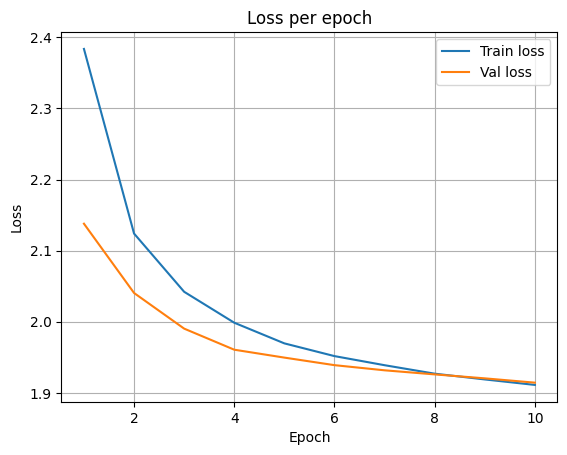

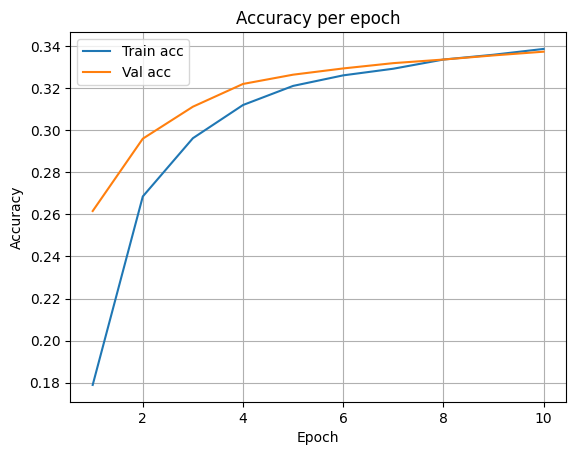

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure()
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in hist and 'val_accuracy' in hist:
    plt.figure()
    plt.plot(epochs, hist['accuracy'], label='Train acc')
    plt.plot(epochs, hist['val_accuracy'], label='Val acc')
    plt.title('Accuracy per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("history.metrics içinde accuracy bulunamadı.")


# 1000 altı temizlik


In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

TEXT_COL   = "clean_text_x"
TARGET_COL = "product"
THRESH     = 1000


mask = df[TARGET_COL].notna() & df[TEXT_COL].notna()
df_use = df.loc[mask, [TEXT_COL, TARGET_COL]].copy()
df_use[TEXT_COL] = df_use[TEXT_COL].astype(str)
df_use[TARGET_COL] = df_use[TARGET_COL].astype(str)

X = df_use[TEXT_COL].to_numpy()
y = df_use[TARGET_COL].to_numpy()

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_counts_before = pd.Series(y_tr).value_counts().sort_values(ascending=False)
test_counts_before  = pd.Series(y_te).value_counts().sort_values(ascending=False)

allowed_classes = train_counts_before[train_counts_before >= THRESH].index.tolist()
removed_classes = train_counts_before[train_counts_before < THRESH]

print("=== TRAIN sınıf sayıları (ÖNCE) ===")
print(train_counts_before)
print("\n=== TEST sınıf sayıları (ÖNCE) ===")
print(test_counts_before)

print("\n=== Eşik altı (train<%d) sınıflar ===" % THRESH)
print(removed_classes if not removed_classes.empty else "Yok")

print("\nKalacak sınıflar (>= %d): %s" % (THRESH, list(allowed_classes)))

def filter_by_allowed(X_arr, y_arr, allowed):
    keep = np.isin(y_arr, allowed)
    return X_arr[keep], y_arr[keep]

X_tr_f, y_tr_f = filter_by_allowed(X_tr, y_tr, allowed_classes)
X_te_f, y_te_f = filter_by_allowed(X_te, y_te, allowed_classes)

train_counts_after = pd.Series(y_tr_f).value_counts().sort_values(ascending=False)
test_counts_after  = pd.Series(y_te_f).value_counts().sort_values(ascending=False)

print("\n=== TRAIN (SONRA, filtrelenmiş) ===")
print(train_counts_after)
print("Toplam train önce:", len(y_tr), "→ sonra:", len(y_tr_f),
      "| Sınıf sayısı önce:", len(train_counts_before), "→ sonra:", len(train_counts_after))

print("\n=== TEST (SONRA, filtrelenmiş) ===")
print(test_counts_after)
print("Toplam test önce:", len(y_te), "→ sonra:", len(y_te_f),
      "| Sınıf sayısı önce:", len(test_counts_before), "→ sonra:", len(test_counts_after))


X_tr, y_tr, X_te, y_te = X_tr_f, y_tr_f, X_te_f, y_te_f
print("Train (filtered):", len(y_tr), " | Test (filtered):", len(y_te))




=== TRAIN sınıf sayıları (ÖNCE) ===
Mortgage                                                                        18180
Checking or savings account                                                      9717
Credit card or prepaid card                                                      8637
Bank account or service                                                          7853
Credit reporting, credit repair services, or other personal consumer reports     3448
Debt collection                                                                  2561
Money transfer, virtual currency, or money service                               1200
Consumer Loan                                                                     823
Vehicle loan or lease                                                             714
Student loan                                                                      693
Money transfers                                                                   182
Payday loan, title

In [ ]:
# === A) TRAIN'e göre 1000 altını SİL ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

TEXT_COL   = "clean_text_x"
TARGET_COL = "product"
THRESH     = 1000

# 0) NA temizliği + tipler
mask   = df[TARGET_COL].notna() & df[TEXT_COL].notna()
df_use = df.loc[mask, [TEXT_COL, TARGET_COL]].copy()
df_use[TEXT_COL]   = df_use[TEXT_COL].astype(str)
df_use[TARGET_COL] = df_use[TARGET_COL].astype(str)

# 1) Split (DataFrame olarak, indexleri koruyalım)
df_tr, df_te = train_test_split(
    df_use, test_size=0.20, random_state=42, stratify=df_use[TARGET_COL]
)

# 2) TRAIN sınıf sayımları ve eşik
train_counts = df_tr[TARGET_COL].value_counts().sort_values(ascending=False)
allowed      = train_counts[train_counts >= THRESH].index
removed      = train_counts[train_counts <  THRESH]

print("=== TRAIN sınıf sayımları (ÖNCE) ===")
print(train_counts)
print("\nSilinecek (TRAIN<%d):" % THRESH)
print(removed if not removed.empty else "Yok")
print("\nKalacak sınıflar:", list(allowed))

# 3) TRAIN/TEST'i allowed ile filtrele (silme)
df_tr_f = df_tr[df_tr[TARGET_COL].isin(allowed)].copy()
df_te_f = df_te[df_te[TARGET_COL].isin(allowed)].copy()

print("\n=== TRAIN (SONRA) ===")
print(df_tr_f[TARGET_COL].value_counts().sort_values(ascending=False))
print("Train önce:", len(df_tr), "→ sonra:", len(df_tr_f),
      "| Sınıf önce:", df_tr[TARGET_COL].nunique(), "→ sonra:", df_tr_f[TARGET_COL].nunique())

print("\n=== TEST (SONRA) ===")
print(df_te_f[TARGET_COL].value_counts().sort_values(ascending=False))
print("Test önce:", len(df_te), "→ sonra:", len(df_te_f),
      "| Sınıf önce:", df_te[TARGET_COL].nunique(), "→ sonra:", df_te_f[TARGET_COL].nunique())

# (Opsiyonel) TRAIN'e göre belirlenen allowed sınıfları tüm veriye uygula → kalıcı temiz tablo
df_clean = df_use[df_use[TARGET_COL].isin(allowed)].copy().reset_index(drop=True)
print("\nTÜM VERİ: önce:", len(df_use), "→ sonra:", len(df_clean),
      "| Sınıf:", df_clean[TARGET_COL].nunique())


=== TRAIN sınıf sayımları (ÖNCE) ===
product
Mortgage                                                                        18180
Checking or savings account                                                      9717
Credit card or prepaid card                                                      8637
Bank account or service                                                          7853
Credit reporting, credit repair services, or other personal consumer reports     3448
Debt collection                                                                  2561
Money transfer, virtual currency, or money service                               1200
Consumer Loan                                                                     823
Vehicle loan or lease                                                             714
Student loan                                                                      693
Money transfers                                                                   182
Payday lo

#7 sınıf +LSTM

In [ ]:
# === B) LSTM: sadece filtrelenmiş TRAIN/TEST ile ===
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense
import numpy as np

X_tr = df_tr_f[TEXT_COL].to_numpy()
y_tr = df_tr_f[TARGET_COL].to_numpy()
X_te = df_te_f[TEXT_COL].to_numpy()
y_te = df_te_f[TARGET_COL].to_numpy()

print("Train (filtered):", len(y_tr), "| Test (filtered):", len(y_te))


enc = LabelEncoder()
y_tr_enc = enc.fit_transform(y_tr)
y_te_enc = enc.transform(y_te)
num_classes = len(enc.classes_)
print("Sınıf sayısı:", num_classes)


MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_tr)

seq_tr = tokenizer.texts_to_sequences(X_tr)
seq_te = tokenizer.texts_to_sequences(X_te)

lens    = np.array([len(s) for s in seq_tr if len(s) > 0] + [1])
MAX_LEN = int(np.clip(np.percentile(lens, 90), 40, 300))
print("MAX_LEN:", MAX_LEN)

X_tr_pad = pad_sequences(seq_tr, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
X_te_pad = pad_sequences(seq_te, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")

assert X_tr_pad.shape[0] == y_tr_enc.shape[0]
assert X_te_pad.shape[0] == y_te_enc.shape[0]

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

classes_unique = np.unique(y_tr_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes_unique, y=y_tr_enc)

MAX_W = 25.0
class_weights = {int(c): float(min(w, MAX_W)) for c, w in zip(classes_unique, weights)}
print("class_weights:", class_weights)


opt = tf.keras.optimizers.Adam(learning_rate=2e-4, clipnorm=1.0)

def build_lstm_model(vocab_size, seq_len, num_classes,
                     emb_dim=128, lstm_units=64, drop=0.5, rdrop=0.2):
    m = Sequential([
        Input(shape=(seq_len,), dtype="int32"),
        Embedding(vocab_size, emb_dim, mask_zero=True),
        LSTM(lstm_units, return_sequences=True, dropout=drop, recurrent_dropout=rdrop),
        Bidirectional(LSTM(lstm_units, dropout=drop, recurrent_dropout=rdrop)),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

tf.keras.backend.clear_session()
model = build_lstm_model(vocab_size=vocab_size, seq_len=MAX_LEN, num_classes=num_classes)

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=2e-5, verbose=1)
ckpt       = ModelCheckpoint("best_lstm.weights.h5", save_best_only=True, save_weights_only=True,
                             monitor="val_loss", mode="min", verbose=1)

history = model.fit(
    X_tr_pad, y_tr_enc,
    validation_data=(X_te_pad, y_te_enc),
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)

y_pred = model.predict(X_te_pad, batch_size=256, verbose=0).argmax(axis=1)
print("\nLSTM Sınıflandırma Raporu (TRAIN<%d silinmiş)" % THRESH)
print(classification_report(y_te_enc, y_pred, target_names=list(enc.classes_), digits=2, zero_division=0))
print(f"Doğruluk: %{accuracy_score(y_te_enc, y_pred)*100:.2f}")


Train (filtered): 51596 | Test (filtered): 12900
Sınıf sayısı: 7
MAX_LEN: 246
class_weights: {0: 0.9386039911953575, 1: 0.7585527573178082, 2: 0.8534047867149639, 3: 2.137719588995691, 4: 2.878116807050817, 5: 6.142380952380952, 6: 0.4054376866258054}
Epoch 1/20
807/807 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2850 - loss: 1.8742
Epoch 1: val_loss improved from inf to 1.71139, saving model to best_lstm.weights.h5
807/807 ━━━━━━━━━━━━━━━━━━━━ 1029s 1s/step - accuracy: 0.2851 - loss: 1.8741 - val_accuracy: 0.4356 - val_loss: 1.7114 - learning_rate: 2.0000e-04
Epoch 2/20
807/807 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4347 - loss: 1.6621
Epoch 2: val_loss improved from 1.71139 to 1.67183, saving model to best_lstm.weights.h5
807/807 ━━━━━━━━━━━━━━━━━━━━ 976s 1s/step - accuracy: 0.4347 - loss: 1.6621 - val_accuracy: 0.4422 - val_loss: 1.6718 - learning_rate: 2.0000e-04
Epoch 3/20
807/807 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4510 - loss: 1.6077
Epoch 3: val_loss improved

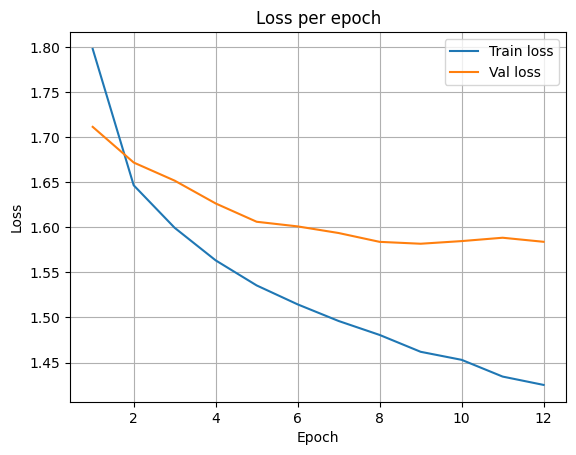

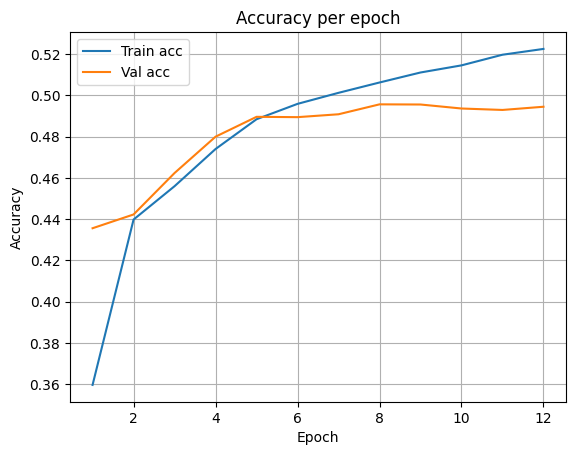

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure()
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in hist and 'val_accuracy' in hist:
    plt.figure()
    plt.plot(epochs, hist['accuracy'], label='Train acc')
    plt.plot(epochs, hist['val_accuracy'], label='Val acc')
    plt.title('Accuracy per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("history.metrics içinde accuracy bulunamadı.")


In [ ]:
!pip install -q gensim==4.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 47.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
pip install --upgrade --force-reinstall "numpy==1.26.4" "scipy==1.11.4"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >=

# Word2Vec +LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, SpatialDropout1D, GlobalMaxPooling1D


TEXT_COL = "clean_text_x"
TARGET_COL = "product"
MAX_WORDS  = 20000
EMB_DIM    = 200
LR         = 2e-4
MAX_W_CAP  = 25.0
SEED       = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

X_tr = df_tr_f[TEXT_COL].astype(str).to_numpy()
y_tr = df_tr_f[TARGET_COL].astype(str).to_numpy()
X_te = df_te_f[TEXT_COL].astype(str).to_numpy()
y_te = df_te_f[TARGET_COL].astype(str).to_numpy()

print("Train (filtered):", len(y_tr), "| Test (filtered):", len(y_te))


enc = LabelEncoder()
y_tr_enc = enc.fit_transform(y_tr)
y_te_enc = enc.transform(y_te)
num_classes = len(enc.classes_)
print("Sınıf sayısı:", num_classes)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_tr)

seq_tr = tokenizer.texts_to_sequences(X_tr)
seq_te = tokenizer.texts_to_sequences(X_te)

lens    = np.array([len(s) for s in seq_tr if len(s) > 0] + [1])
MAX_LEN = int(np.clip(np.percentile(lens, 90), 40, 300))
print("MAX_LEN:", MAX_LEN)

X_tr_pad = pad_sequences(seq_tr, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
X_te_pad = pad_sequences(seq_te, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")

assert X_tr_pad.shape[0] == y_tr_enc.shape[0]
assert X_te_pad.shape[0] == y_te_enc.shape[0]

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)


index_word = {idx: w for w, idx in tokenizer.word_index.items()}

sentences_tok = [[index_word.get(i) for i in seq if i != 0] for seq in seq_tr]
sentences_tok = [[w for w in sent if w is not None] for sent in sentences_tok]

w2v = Word2Vec(
    sentences=sentences_tok,
    vector_size=200,
    window=5,
    min_count=2,
    sg=1,
    negative=10,
    epochs=10,
    workers=4
)


embedding_matrix = np.random.normal(0.0, 0.01, size=(vocab_size, 200)).astype("float32")
embedding_matrix[0] = 0.0

oov_idx = tokenizer.word_index.get(tokenizer.oov_token)
if oov_idx is not None and oov_idx < vocab_size:
    embedding_matrix[oov_idx] = 0.0

wv = w2v.wv
found = 0
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size and word in wv.key_to_index:
        embedding_matrix[idx] = wv[word]
        found += 1

print(f"Embedding coverage: {found}/{vocab_size} ({found*100.0/vocab_size:.1f}%)")


classes_unique = np.unique(y_tr_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes_unique, y=y_tr_enc)
class_weights = {int(c): float(min(w, MAX_W_CAP)) for c, w in zip(classes_unique, weights)}
print("class_weights:", class_weights)


def build_lstm_model(vocab_size, seq_len, num_classes,
                     emb_dim=200, lstm_units=64, drop=0.5, lr=LR,
                     emb_weights=None, trainable_emb=False):
    m = Sequential([
        Input(shape=(seq_len,), dtype="int32"),
        Embedding(
            input_dim=vocab_size,
            output_dim=emb_dim,
            weights=[emb_weights] if emb_weights is not None else None,
            mask_zero=True,
            trainable=trainable_emb
        ),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=drop, recurrent_dropout=0.2)),
        GlobalMaxPooling1D(),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

tf.keras.backend.clear_session()
model = build_lstm_model(
    vocab_size=vocab_size,
    seq_len=MAX_LEN,
    num_classes=num_classes,
    emb_dim=200,
    emb_weights=embedding_matrix,   # <- Word2Vec'ten gelen matris
    trainable_emb=False             # önce dondur; sonra fine-tune edebilirsin
)
model.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)



history = model.fit(
    X_tr_pad, y_tr_enc,
    validation_data=(X_te_pad, y_te_enc),
    epochs=15,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


test_loss, test_acc = model.evaluate(X_te_pad, y_te_enc, batch_size=256, verbose=0)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}\n")

y_pred = model.predict(X_te_pad, batch_size=256, verbose=0).argmax(axis=1)

print("=== Classification Report ===\n")
print(classification_report(y_te_enc, y_pred, target_names=list(enc.classes_), digits=3, zero_division=0))

# --------------------
# (Opsiyonel) 2. Aşama: Embedding'i açıp küçük LR ile fine-tune
# --------------------
# model.layers[1].trainable = True  # Embedding katmanı
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5, clipnorm=1.0),
#               loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.fit(
#     X_tr_pad, y_tr_enc,
#     validation_data=(X_te_pad, y_te_enc),
#     epochs=3,
#     batch_size=BATCH_SIZE,
#     class_weight=class_weights,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )
# test_loss, test_acc = model.evaluate(X_te_pad, y_te_enc, batch_size=256, verbose=0)
# print(f"\n[Fine-tuned] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}\n")


Train (filtered): 51596 | Test (filtered): 12900
Sınıf sayısı: 7
MAX_LEN: 246
Embedding coverage: 15655/20000 (78.3%)
class_weights: {0: 0.9386039911953575, 1: 0.7585527573178082, 2: 0.8534047867149639, 3: 2.137719588995691, 4: 2.878116807050817, 5: 6.142380952380952, 6: 0.4054376866258054}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning:

Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 246, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 246, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 246, 128)       │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,583 (15.78 MB)

 Trainable params: 136,583 (533.53 KB)

 Non-trainable params: 4,000,000 (15.26 MB)

Epoch 1/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 880s 1s/step - accuracy: 0.3062 - loss: 1.9119 - val_accuracy: 0.3712 - val_loss: 1.8360 - learning_rate: 2.0000e-04
Epoch 2/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/step - accuracy: 0.3895 - loss: 1.7821 - val_accuracy: 0.4422 - val_loss: 1.6941 - learning_rate: 2.0000e-04
Epoch 3/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - accuracy: 0.4234 - loss: 1.7071 - val_accuracy: 0.4680 - val_loss: 1.6446 - learning_rate: 2.0000e-04
Epoch 4/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 870s 1s/step - accuracy: 0.4427 - loss: 1.6698 - val_accuracy: 0.4848 - val_loss: 1.6079 - learning_rate: 2.0000e-04
Epoch 5/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 920s 1s/step - accuracy: 0.4540 - loss: 1.6517 - val_accuracy: 0.4907 - val_loss: 1.5923 - learning_rate: 2.0000e-04
Epoch 6/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - accuracy: 0.4597 - loss: 1.6322 - val_accuracy: 0.4955 - val_loss: 1.5821 - learning_rate: 2.0000e-04
Epoch 7/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 888s 1s/step - acc

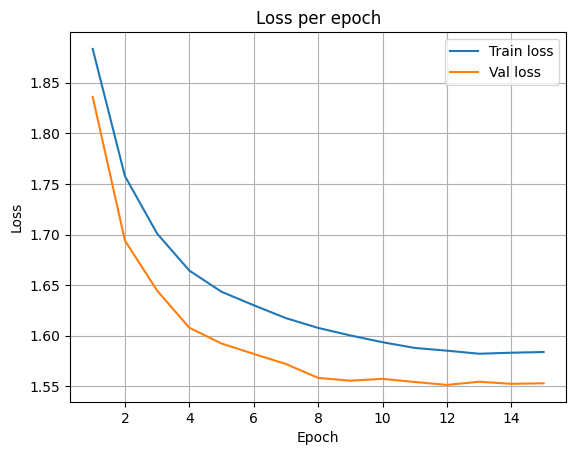

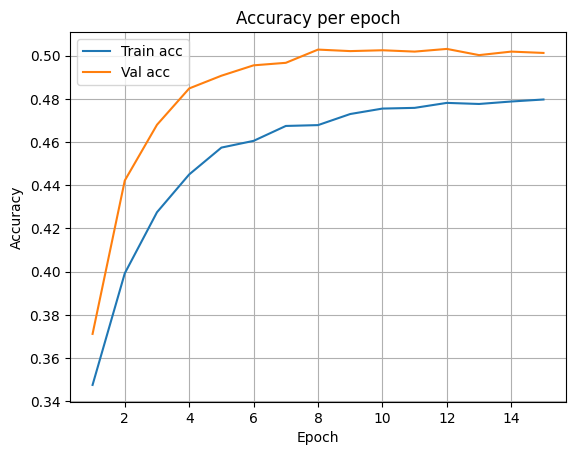

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure()
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in hist and 'val_accuracy' in hist:
    plt.figure()
    plt.plot(epochs, hist['accuracy'], label='Train acc')
    plt.plot(epochs, hist['val_accuracy'], label='Val acc')
    plt.title('Accuracy per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("history.metrics içinde accuracy bulunamadı.")


# FastText +LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from gensim.models import FastText
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, SpatialDropout1D, GlobalMaxPooling1D

# ===== Sabitler =====
TEXT_COL = "clean_text_x"
TARGET_COL = "product"
MAX_WORDS  = 20000
EMB_DIM    = 200
LR         = 2e-4
MAX_W_CAP  = 25.0
SEED       = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

# ===== Hazır train/test bölümleri =====
X_tr = df_tr_f[TEXT_COL].astype(str).to_numpy()
y_tr = df_tr_f[TARGET_COL].astype(str).to_numpy()
X_te = df_te_f[TEXT_COL].astype(str).to_numpy()
y_te = df_te_f[TARGET_COL].astype(str).to_numpy()

print("Train (filtered):", len(y_tr), "| Test (filtered):", len(y_te))

# ===== Label encode =====
enc = LabelEncoder()
y_tr_enc = enc.fit_transform(y_tr)
y_te_enc = enc.transform(y_te)
num_classes = len(enc.classes_)
print("Sınıf sayısı:", num_classes)

# ===== Tokenizer & padding =====
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_tr)

seq_tr = tokenizer.texts_to_sequences(X_tr)
seq_te = tokenizer.texts_to_sequences(X_te)

lens    = np.array([len(s) for s in seq_tr if len(s) > 0] + [1])
MAX_LEN = int(np.clip(np.percentile(lens, 90), 40, 300))
print("MAX_LEN:", MAX_LEN)

X_tr_pad = pad_sequences(seq_tr, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
X_te_pad = pad_sequences(seq_te, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")

assert X_tr_pad.shape[0] == y_tr_enc.shape[0]
assert X_te_pad.shape[0] == y_te_enc.shape[0]

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

# ===== FastText için cümle listesi =====
index_word = {idx: w for w, idx in tokenizer.word_index.items()}
sentences_tok = [[index_word.get(i) for i in seq if i != 0] for seq in seq_tr]
sentences_tok = [[w for w in sent if w is not None] for sent in sentences_tok]

# ===== FastText eğitimi (subword destekli) =====
# Not: FastText, görmediği kelimeler için de karakter n-gramlarından vektör üretebilir.
ft = FastText(
    sentences=sentences_tok,
    vector_size=EMB_DIM,
    window=5,
    min_count=2,
    sg=1,          # skip-gram (Word2Vec ile aynı ayar)
    negative=10,
    epochs=10,
    workers=4
)
wv = ft.wv

# ===== Embedding matrisi (FastText) =====
embedding_matrix = np.random.normal(0.0, 0.01, size=(vocab_size, EMB_DIM)).astype("float32")
embedding_matrix[0] = 0.0  # padding vektörü

oov_idx = tokenizer.word_index.get(tokenizer.oov_token)
if oov_idx is not None and oov_idx < vocab_size:
    embedding_matrix[oov_idx] = 0.0

found = 0
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    # FastText: OOV için de get_vector çalışır (subword ile tahmin eder)
    vec = wv.get_vector(word, norm=False)
    embedding_matrix[idx] = vec
    if word in wv.key_to_index:
        found += 1

print(f"Embedding coverage (in-vocab): {found}/{vocab_size} ({found*100.0/vocab_size:.1f}%)")
print("Not: FastText OOV kelimeler için de subword ile vektör üretebilir.")

# ===== Sınıf ağırlıkları =====
classes_unique = np.unique(y_tr_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes_unique, y=y_tr_enc)
class_weights = {int(c): float(min(w, MAX_W_CAP)) for c, w in zip(classes_unique, weights)}
print("class_weights:", class_weights)

# ===== Model =====
def build_lstm_model(vocab_size, seq_len, num_classes,
                     emb_dim=EMB_DIM, lstm_units=64, drop=0.5, lr=LR,
                     emb_weights=None, trainable_emb=False):
    m = Sequential([
        Input(shape=(seq_len,), dtype="int32"),
        Embedding(
            input_dim=vocab_size,
            output_dim=emb_dim,
            weights=[emb_weights] if emb_weights is not None else None,
            mask_zero=True,
            trainable=trainable_emb
        ),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=drop, recurrent_dropout=0.2)),
        GlobalMaxPooling1D(),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

tf.keras.backend.clear_session()
model = build_lstm_model(
    vocab_size=vocab_size,
    seq_len=MAX_LEN,
    num_classes=num_classes,
    emb_dim=EMB_DIM,
    emb_weights=embedding_matrix,   # <- FastText'ten gelen matris
    trainable_emb=False             # önce dondur; sonra küçük LR ile fine-tune edebilirsin
)
model.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    X_tr_pad, y_tr_enc,
    validation_data=(X_te_pad, y_te_enc),
    epochs=15,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ===== Değerlendirme =====
test_loss, test_acc = model.evaluate(X_te_pad, y_te_enc, batch_size=256, verbose=0)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}\n")

y_pred = model.predict(X_te_pad, batch_size=256, verbose=0).argmax(axis=1)

print("=== Classification Report ===\n")
print(classification_report(y_te_enc, y_pred, target_names=list(enc.classes_), digits=3, zero_division=0))

# --------------------
# (Opsiyonel) 2. Aşama: Embedding'i açıp küçük LR ile fine-tune
# --------------------
# model.layers[1].trainable = True  # Embedding katmanı
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5, clipnorm=1.0),
#               loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.fit(
#     X_tr_pad, y_tr_enc,
#     validation_data=(X_te_pad, y_te_enc),
#     epochs=3,
#     batch_size=64,
#     class_weight=class_weights,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )
# test_loss, test_acc = model.evaluate(X_te_pad, y_te_enc, batch_size=256, verbose=0)
# print(f"\n[Fine-tuned] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}\n")


Train (filtered): 51596 | Test (filtered): 12900
Sınıf sayısı: 7
MAX_LEN: 246
Embedding coverage (in-vocab): 15655/20000 (78.3%)
Not: FastText OOV kelimeler için de subword ile vektör üretebilir.
class_weights: {0: 0.9386039911953575, 1: 0.7585527573178082, 2: 0.8534047867149639, 3: 2.137719588995691, 4: 2.878116807050817, 5: 6.142380952380952, 6: 0.4054376866258054}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning:

Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 246, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 246, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 246, 128)       │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,583 (15.78 MB)

 Trainable params: 136,583 (533.53 KB)

 Non-trainable params: 4,000,000 (15.26 MB)

Epoch 1/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 882s 1s/step - accuracy: 0.2230 - loss: 1.9169 - val_accuracy: 0.3693 - val_loss: 1.8389 - learning_rate: 2.0000e-04
Epoch 2/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 922s 1s/step - accuracy: 0.3863 - loss: 1.7823 - val_accuracy: 0.4266 - val_loss: 1.7118 - learning_rate: 2.0000e-04
Epoch 3/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 919s 1s/step - accuracy: 0.4180 - loss: 1.7102 - val_accuracy: 0.4595 - val_loss: 1.6512 - learning_rate: 2.0000e-04
Epoch 4/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 919s 1s/step - accuracy: 0.4373 - loss: 1.6715 - val_accuracy: 0.4752 - val_loss: 1.6193 - learning_rate: 2.0000e-04
Epoch 5/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 868s 1s/step - accuracy: 0.4492 - loss: 1.6470 - val_accuracy: 0.4922 - val_loss: 1.5972 - learning_rate: 2.0000e-04
Epoch 6/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/step - accuracy: 0.4564 - loss: 1.6343 - val_accuracy: 0.4958 - val_loss: 1.5813 - learning_rate: 2.0000e-04
Epoch 7/15
807/807 ━━━━━━━━━━━━━━━━━━━━ 927s 1s/step - acc

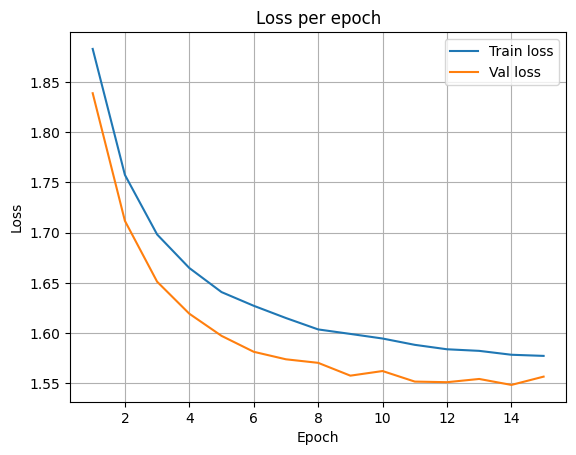

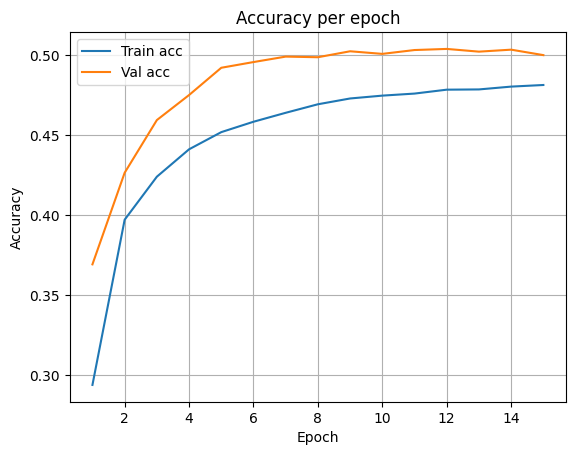

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure()
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in hist and 'val_accuracy' in hist:
    plt.figure()
    plt.plot(epochs, hist['accuracy'], label='Train acc')
    plt.plot(epochs, hist['val_accuracy'], label='Val acc')
    plt.title('Accuracy per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("history.metrics içinde accuracy bulunamadı.")
